# Setup

## Option A: Insert Google Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

my_path = '/content/drive/MyDrive/Colab Notebooks/mc_sa_ml'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Option B: Import from Github

In [ ]:
!git clone https://github.com/TorbenOestergaard/mc_sa_ml.git

my_path = 'mc_sa_ml/SAtom'

Cloning into 'mc_sa_ml'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 3), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (16/16), done.


## Option C: Clone git and run locally

## Import dependencies

In [13]:
from os import path, makedirs
import sys
from google.colab import files
import io

if path.exists(my_path):
  print(f'Found path: {my_path}')  
  sys.path.append(my_path)
  import SAtom2 as sa

else:
  print(f'Could not locate path: {my_path}')


# Data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output 
from ipywidgets import Dropdown
from os import path, makedirs

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

global y_train_pred
global y_train_full_pred
global y_valid_pred
global y_test_pred

Found path: mc_sa_ml/SAtom


## Helper functions

In [5]:
def create_new_samples(X_pdfs, N):
  """
  Sample N new inputs from probability densitity distributions (PDF).
  Distributions are limited to uniform, continuous and uniform, discrete.
      
  Parameters
  ----------
      X_pdfs : dictionary, decription of PDF for each variable input in X
      N : int, number of new samples
  """  
  # Initialize array for new samples and list for inputs labels
  x_arr = np.zeros([N, len(X_pdfs)])
  x_labels = []

  # Loop through dictionary - each describing variable input, Xi
  for i, (xvar, nest_dict) in enumerate(X_pdfs.items()):
    x_labels = x_labels + [nest_dict['param']]

    if nest_dict['pdf'] == 'uniform':
      x_temp = np.random.uniform(nest_dict['args'][0], nest_dict['args'][1], N)
    elif nest_dict['pdf'] == 'discrete':
      x_temp = np.random.choice(nest_dict['args'], N)

    x_arr[:,i] = np.reshape(x_temp,-1)
  
  X_new = pd.DataFrame(x_arr, columns=x_labels)

  return X_new

In [6]:
def print_R2_performance(model, test=False):
    """
    Print R2 score for training and validation set
    
    Requires: x_train_prepared, x_valid_prepared, y_train, y_valid
    
    Parameters
    ----------
        model : scikit-learn model
        test : boolean, True to include performance on test set
    """
    y_train_pred = model.predict(x_train_full.values)
    # y_valid_pred = model.predict(x_valid_prepared)
    r2_train = r2_score(y_train_full, y_train_pred)
    # r2_valid = r2_score(y_valid, y_valid_pred)
#     message = f'R²(train) = {r2_train:.3f} \t R²(valid) = {r2_valid:.3f}'
    message = f'# {r2_train:.3f}'#' / {r2_valid:.3f}'
    
    if test:
        y_test_pred = model.predict(x_test.values)
        r2_test = r2_score(y_test, y_test_pred)
        message = message + f' / {r2_test:.3f}'
    print(message)

In [7]:
def make_predictions(model):
  y_train_pred = model.predict(x_train_prepared)
  y_train_full_pred = model.predict(x_train_full_prepared)
  y_valid_pred = model.predict(x_valid_prepared)
  y_test_pred = model.predict(x_test_prepared)
  return y_train_pred, y_train_full_pred, y_valid_pred, y_test_pred


In [8]:
def sa_multiple(X, Y, J=50, include_SA_all=False, sort_by=None, figsize='auto'):
  """Perform sensitivity analysis for each output in matrix using SAtom

  Parameters:
  -----------
  X (pandas.DataFrame): DataFrame with numeric input values
  Y (pandas.DataFrame): DataFrame with numeric output values
  J : int, default=50
    Number of repeated randomly selected samples. 
  include_SA_all : {True, False}, default=False
    If True, TOM SA will also be performed for all outputs
  sort_by : {None, 'alphabetically', 'all'} or output label
    Decide how to sort the input labels on bar plots, e.g. using SA values.  
  figsize : {'auto', (float, float)} figure width and height in inches. 'auto'
    will set the figure size automatically from the number of inputs and outputs  

  Returns:
  --------
  Y_SA (pandas.DataFrame): indexed with input names and columns with SA metrics
    for each output
  fig (matplotlib.Figure): plot figure

  References
  ----------
  Østergård, T., Jensen, R.L., and Maagaard, S.E. (2017)
      Interactive Building Design Space Exploration Using Regionalized 
      Sensitivity Analysis, 15th conference of the International Building 
      Performance Simulation Association, 7-9 August 2017, San Francisco, USA  

  """
  
  n_outputs = Y.shape[1] + 1 if include_SA_all else Y.shape[1]
  n_inputs = Y.shape[1]
  Y_SA = np.zeros([X.shape[1], Y.shape[1]])

  # Loop and perform SA for each output
  for i, col in enumerate(Y.columns):
    print(f'({i+1}/{n_outputs}) {"Performs TOM SA for:" :>20}  {col}')
    tom = sa.TOM(X, Y[col], J=J, verbose=False, dummy=False)
    KS_means = np.reshape(np.transpose(tom.KS_df.tail(1).values),-1)
    KS_means = KS_means / sum(KS_means) * 100 # Convert to percentages
    Y_SA[:, i] = KS_means

  # Convert array to DataFrame
  Y_SA = pd.DataFrame(data=Y_SA, index=list(X.columns.values), columns=Y.columns)
  
  if include_SA_all:
    print(f'({n_outputs}/{n_outputs}) {"Performs TOM SA for:" :>20}  All outputs')
    tom = sa.TOM(X, Y, J=J*2, verbose=False, dummy=False)
    KS_means = np.reshape(np.transpose(tom.KS_df.tail(1).values),-1)
    KS_means = KS_means / sum(KS_means) * 100 # Convert to percentages    
    Y_SA.insert (0, "All", KS_means)

  # Sort inputs by output(s)
  if sort_by != None:
    if sort_by == 'alphabetically':
      Y_SA.sort_index(axis=0, inplace=True)
    if sort_by == 'all':
      if include_SA_all == True:
        Y_SA = Y_SA.sort_values(by='All', ascending=False) 
    if sort_by in Y_SA.columns:
      Y_SA = Y_SA.sort_values(by=sort_by, ascending=False) 

  # Plot distributions and horisontal barplots with SA results
  print('Preparing plots')
  
  if figsize == 'auto': figsize = (2+n_outputs*1.7, 2+n_inputs*.3)
  fig, axes = plt.subplots(2, n_outputs, 
                           figsize=figsize,  # (2+n_outputs*1.7, 1+n_inputs*1)
                           constrained_layout=True, gridspec_kw={'height_ratios': [1, 3]},
                           ) #  sharey='row',

  for i_plot in range(n_outputs):
    # Create histograms (except for "all outputs")
    if i_plot == 0 and include_SA_all == True:
      axes[0,0].axis('off')
    else:
      sns.histplot(ax=axes[0, i_plot], data=Y, x=Y_SA.columns[i_plot], 
                 stat="probability", element="step", fill=True, bins=25)
    
    # Create SA bar plots            
    sns.barplot(ax=axes[1, i_plot], y=Y_SA.index, x=Y_SA.iloc[:,i_plot])
    axes[1, i_plot].spines['top'].set_visible(False)  
    axes[1, i_plot].spines['right'].set_visible(False)  

    # Add labels
    for i, val in enumerate(Y_SA.iloc[:,i_plot].values):
        axes[1, i_plot].text(val+0.1, i+0.2, str(round(val,1)), size=8)

    axes[0, i_plot].set_title(Y_SA.columns[i_plot], fontsize=10)
    axes[0, i_plot].xaxis.label.set_visible(False)
    if i_plot >= 1:
      axes[0, i_plot].get_yaxis().set_visible(False)
      axes[1, i_plot].get_yaxis().set_visible(False)
    else:
      axes[0, i_plot].yaxis.set_ticks([])

  return Y_SA, fig

In [9]:
import math
round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

def obtain_pdfs(X, n_significant_figures=3, verbose=True):
  """
  Obtain pdfs for each column in an input sample matrix, X.
  Assumes discrete distribution if number of unique values are less than 20, 
  otherwise a continuous, uniform distribution 
  
  Parameters
  ----------
    X {DataFrame} : Monte Carlo input values
    n_significat_figures : integer to round min/max values for uniform PDF

  Returns:
  --------
    X_pdfs {dict} : nested dict for each column in X
      e.g. 'x1' : {'idx':0, 'param': 'myvar', 'pdf': 'uniform', 'args': [0 2]}
  """
  X_pdfs = {}
  n_max_letters = len(max(X.columns, key=len)) + 2 # For optimal space in print
  for i, col in enumerate(X.columns):
    if len(X[col].unique()) <= 20:
      pdf = 'discrete'
      args = X[col].unique()
    else:
      pdf = 'uniform'      
      args = [round_to_n(X[col].min(), n_significant_figures), 
              round_to_n(X[col].max(), n_significant_figures)]
    
    X_pdfs['x'+str(i)] = {'idx':i, 'param':col, 'pdf':pdf, 'args':args}    
    
    if verbose:
      print(f'x{str(i):<2} {col:<{n_max_letters}} {pdf:<10} {args}')

  return X_pdfs

In [10]:
def ordinal_decode_cat_hyperparameters(cvres_df):
  """
  Ordinal decode categorical columns in grid search results' dataframe.
  Afterwards, sensitivity analysis can be performed to see which hyperparameters
  seems to affect the RMSE performance the most.
  
  Parameters
  ----------
    cvres_df {DataFrame} : Grid-search values and corresponding RMSE score

  Returns:
  --------
    cvres_df
  """
  numerical_attr = cvres_df.select_dtypes(include=['float64', 'int64']).columns
  ord_attr = cvres_df.select_dtypes(exclude=['float64', 'int64']).columns

  ordinal_pipeline = Pipeline([('encode', OrdinalEncoder())])
  small_pipeline = ColumnTransformer([("ord", ordinal_pipeline, ord_attr)], 
                                    remainder='passthrough')
  cvres_df = small_pipeline.fit_transform(cvres_df)

  # Convert transformed array to frame and reinsert RMSE as first column
  cvres_df = pd.DataFrame(cvres_df, columns=list(ord_attr) + list(numerical_attr))
  rmse_column = cvres_df.pop('RMSE')
  cvres_df.insert(0, 'RMSE', rmse_column)

  return cvres_df

# Choose datafile

## Upload file

In [36]:
uploaded = files.upload()

Saving mongo_v2.csv to mongo_v2.csv


In [37]:
filename_monte_carlo = list(uploaded.keys())[0]
file_full_path = filename_monte_carlo

## Read file

In [38]:
file_extension = filename_monte_carlo.split(".")[-1]
file_name_only = filename_monte_carlo[:-(len(file_extension)+1)]

if file_extension == 'xlsx':
  # Excel file. If data in specific sheet, add argument: sheet_name='Sheet1'
  XY_raw = pd.read_excel(file_full_path, header=0, engine="openpyxl", )
elif file_extension == 'csv' or file_extension == 'txt':
  XY_raw = pd.read_csv(file_full_path, sep=None)

XY = XY_raw.copy()
print(f'Shape of data: {XY_raw.shape}')
XY_raw.head()

Shape of data: (241, 12)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  


,in:Floor height m,in:window tilt degrees,in:sill height,in:Hzl glz percent,in:SF,in:Blind position,out:minimum Daylight,out:Average daylight,out:Maximum solar heat gain kWh/m²,out:Cooling load kWh/m²,out:Heating load kWh/m²,out:Lighting kWh/m²
0,82.500,8.00,0.425,0.80,32,0,40.190250,62.389351,38.278610,7.545635,3.342618,9.503185
1,43.750,11.50,0.238,0.90,38,0,45.342846,65.724226,53.790704,8.596303,4.181430,8.979453
2,121.250,4.50,0.613,0.70,27,1,36.068173,60.342626,28.240105,7.067837,2.859843,9.522994
3,24.375,9.75,0.706,0.95,32,1,36.068173,61.544898,39.300877,7.792447,3.712335,9.382797
4,101.875,2.75,0.331,0.75,38,0,54.617519,70.833884,51.687360,8.418060,2.866525,8.742886


Transform categorical features to numeric

In [35]:
# Obtain labels for categorical features (if present)
ord_attr = XY_raw.select_dtypes(exclude=['float64', 'int64']).columns

if len(ord_attr) == 0:
  display(f'No categorical features detected.')
  XY = XY_raw.copy()

else:
  display(f'Found categorical features: {ord_attr}')

  # Pipeline for ordinal encoder
  ordinal_pipeline = Pipeline([
                              ('imputer', SimpleImputer(strategy="most_frequent")),
                              ('encode', OrdinalEncoder()),
                              ])

  # Full pipeline, transform categorical features and update dataframe
  full_pipeline = ColumnTransformer([("ord", ordinal_pipeline, ord_attr),],
                                    remainder='passthrough')
  XY_arr = full_pipeline.fit_transform(XY_raw)

  XY = pd.DataFrame(XY_arr, columns=ord_attr.to_list() + XY_raw.columns.drop(ord_attr).to_list())
  XY.head()

'No categorical features detected.'

Specify the number of inputs and outputs

In [39]:
n_inputs = 6  # Angiv antallet af inputkolonner
n_outputs = 6   # Angiv antallet af outputkolonner

N = XY.shape[0]
X = XY.iloc[:N, :n_inputs]
Y = XY.iloc[:N, -n_outputs:]

Save as txt-file for DataExplorer

In [ ]:
print('Saving to: ' + my_path + filename_monte_carlo[:-4] + 'csv')
# XY.to_csv(my_path + filename_monte_carlo[:-4] + 'csv', sep='\t', index=False)

Saving to: /content/drive/MyDrive/Colab Notebooks/data 11.08 data explorer-LTcsv


# Sensitivity Analysis

## Single output

Use dropdown to specify which output should be addressed in the sensitivity analysis.

In [40]:
output_labels = list(Y.columns)
dropdown = Dropdown(options= ['All'] + list(output_labels), description='Output(s):')
dropdown

Dropdown(description='Output(s):', options=('All', 'out:minimum Daylight', 'out:Average daylight', 'out:Maximu…

Set sensitivy arguments and perform analysis.  
For large datasets, start with a small J value (e.g. 50) for a single output and see if the SA estimates have converged. If not, increase J until they converge. 

Performing sensitivity analysis for: out:minimum Daylight
     N, simulations:  241
          N, inputs:  7
         N, outputs:  1
                  J:  100
            Q, size:  120
         Calc. time:  0.240 s


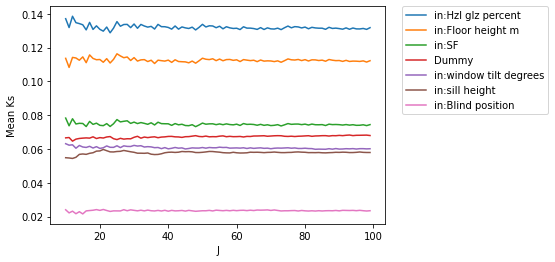

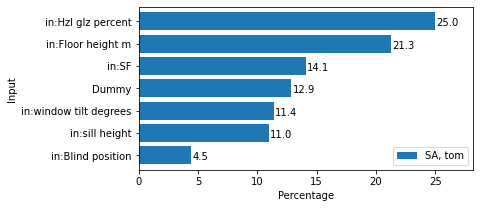

In [41]:
J = 100              # Number random splits. Increase if values have not converged
add_dummy = True    # Specify if a 'dummy' variable should be added

if dropdown.value == 'All':
  print('Performing sensitivity analysis for all outputs.')
  y = Y.copy()
else:
  print('Performing sensitivity analysis for: ' + dropdown.value)
  y = Y.iloc[:, output_labels.index(dropdown.value)]

tom = sa.TOM(X, y, J=J, verbose=True, dummy=add_dummy)

The J-averaged Kolmogorov-Smirnov distances   ´tom.KS_df´.

In [42]:
df_SA = pd.DataFrame(columns=['Input', 'SA, tom'])
SA_score = tom.KS_df.iloc[-1,:].values # Den sidste række (J'te sample) bruges
SA_score = np.array([(val / sum(SA_score)) * 100 for val in SA_score])
for i, (col, score) in enumerate(zip(tom.KS_df.columns, SA_score)):
  df_SA.loc[i] = [col, score]
df_SA.sort_values(by="SA, tom", ascending=False) 

,Input,"SA, tom"
3,in:Hzl glz percent,24.954477
0,in:Floor height m,21.253200
4,in:SF,14.096400
6,Dummy,12.875152
1,in:window tilt degrees,11.395309
2,in:sill height,10.974143
5,in:Blind position,4.451319


Optionally, order input columns by their influence with respect to a given output (or all outputs). The most influential will then be placed closest to the output columns, which make analysis in [DataExplorer](https://buildingdesign.moe.dk/dataexplorer/) easier. 

In [43]:
filename_export = 'sorted_XY'  # Define filename

XY_export = XY.copy()
sa_sorted_inputs = list(df_SA.drop(df_SA[df_SA['Input'] == 'Dummy'].index).sort_values(by="SA, tom", ascending=True)['Input'])
sorted_columns = sa_sorted_inputs + list(output_labels)
XY_export = XY_export[sorted_columns]

# Save as 
XY_export.to_csv(filename_export + '.csv', sep='\t', index=False)
# XY_export.to_excel(my_path + filename_export + '.xlsx', index=False)

## All outputs
Create a figure with histogram and SA bar plots for all outputs.

(1/6) Performs TOM SA for:  min DA
(2/6) Performs TOM SA for:  Avg DA
(3/6) Performs TOM SA for:  Max solar gain
(4/6) Performs TOM SA for:  Cooling load
(5/6) Performs TOM SA for:  Heating load
(6/6) Performs TOM SA for:  Lighting
Preparing plots


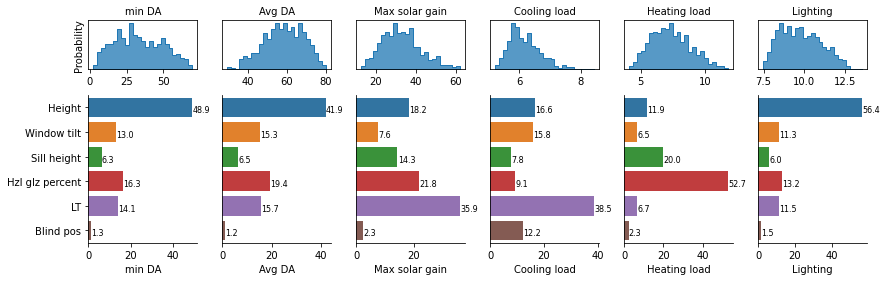

In [ ]:
# Enable figures to be return from function
%config InlineBackend.close_figures = False

res, fig = sa_multiple(X.iloc[:1000,:], 
                       Y.iloc[:1000,:], 
                       J=100, 
                       include_SA_all=False, 
                       sort_by='all')

Optionally, save the figure as jpg, png, or svg.

In [ ]:
SAVE_FIG = False
if SAVE_FIG:
  # fig.savefig(my_path + file_name_only + '_TOM_SA.svg')
  # fig.savefig(my_path + file_name_only + '_TOM_SA.png')  
  fig.savefig(my_path + file_name_only + '_TOM_SA.jpg', dpi=300)

# Machine Learning

## Choose output

In [ ]:
output_labels = list(Y.columns)
dropdown_ml = Dropdown(options=['All (NN only)'] + list(output_labels), description='Output:')
dropdown_ml

Dropdown(description='Output:', options=('All (NN only)', 'min DA', 'Avg DA', 'Max solar gain', 'Cooling load'…

## Prepare data

Split dataset into training set, validation set, and test set.

In [ ]:
VALID_SIZE = 0.25
TEST_SIZE = 0.25
shuffle_state = True
np.random.seed(42)

# Create a test set and a "full" training set to be split into training and validation sets
train_set_full, test_set = train_test_split(XY, test_size=TEST_SIZE, shuffle=shuffle_state)
train_set, valid_set = train_test_split(train_set_full, test_size=(VALID_SIZE / (1 - TEST_SIZE)), shuffle=shuffle_state)

total_sim = train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]
display(f'Total of {total_sim} simulations. Length of data_raw: {len(XY)}.')
display(f'train set {train_set.shape}, valid set{valid_set.shape}, test set {test_set.shape}.')
display(f'Split ratios: {round((train_set.shape[0]/total_sim*100))} / {round((valid_set.shape[0]/total_sim*100))} / {round((test_set.shape[0]/total_sim*100))} %')

'Total of 848 simulations. Length of data_raw: 848.'

'train set (424, 12), valid set(212, 12), test set (212, 12).'

'Split ratios: 50 / 25 / 25 %'

Split each set into input and output subsets and transform data for machine learning.

In [ ]:
x_train_full = train_set_full.iloc[:, :n_inputs]
x_train = train_set.iloc[:, :n_inputs]
x_valid = valid_set.iloc[:, :n_inputs]
x_test = test_set.iloc[:, :n_inputs]

if dropdown_ml.value[:3] == 'All':
  y_train_full = train_set_full.iloc[:, n_inputs:]
  y_train = train_set.iloc[:, n_inputs:]
  y_valid = valid_set.iloc[:, n_inputs:]
  y_test = test_set.iloc[:, n_inputs:]
  y_labels = train_set.iloc[:, n_inputs:].columns.to_list()
else:
  y_train_full = train_set_full[dropdown_ml.value].copy()
  y_train = train_set[dropdown_ml.value].copy()
  y_valid = valid_set[dropdown_ml.value].copy()
  y_test = test_set[dropdown_ml.value].copy()
  y_labels = [dropdown_ml.value]

num_pipeline = Pipeline([('standard_scaler', StandardScaler()),])
numerical_attr = x_train.select_dtypes(include=['float64', 'int64']).columns

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_attr), 
    # ("ord", ordinal_pipeline, ord_attr),
    # ("cat", cat_pipeline, categorical_attr),
])

x_train_prepared = full_pipeline.fit_transform(x_train)
x_train_full_prepared = full_pipeline.fit_transform(x_train_full)
x_valid_prepared = full_pipeline.transform(x_valid)
x_test_prepared = full_pipeline.transform(x_test)

## Train models

### Random Forest

In [ ]:
param_grid = [{'max_depth':[8, 10, 12, ], 'max_features': [2, 3, 4], }]

forest_reg = RandomForestRegressor(n_jobs=-1, verbose=0, bootstrap=False, n_estimators=100,)

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(x_train_full.values, y_train_full.values)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

print(f'\n Best parameters: {grid_search.best_params_} \n R² for validation / test set: ')
rf_best = grid_search.best_estimator_
print_R2_performance(rf_best, test=True)

5.7390106836495445 {'max_depth': 8, 'max_features': 2}
5.006937477748327 {'max_depth': 8, 'max_features': 3}
5.021776522998482 {'max_depth': 8, 'max_features': 4}
5.479765859158836 {'max_depth': 10, 'max_features': 2}
4.7076257824190915 {'max_depth': 10, 'max_features': 3}
4.816510811858643 {'max_depth': 10, 'max_features': 4}
5.479048671201738 {'max_depth': 12, 'max_features': 2}
4.738530396248517 {'max_depth': 12, 'max_features': 3}
4.775617090270629 {'max_depth': 12, 'max_features': 4}

 Best parameters: {'max_depth': 10, 'max_features': 3} 
 R² for validation / test set: 
# 0.999 / 0.909


In [ ]:
params_count = len(cvres['params'][0].keys()) # Number of hyperparameters
params_labels = list(cvres['params'][0].keys()) # Labels for hyperparameters
cvres_df = pd.DataFrame(columns=['score'] + list(cvres['params'][0].keys()))
for i in range(len(cvres['mean_test_score'])):
  cvres_df = cvres_df.append({'score': cvres['mean_test_score'][i], **cvres['params'][i]}, ignore_index=True, )

cvres_df

,score,max_depth,max_features
0,-29123.742857,8.0,2.0
1,-15042.861867,8.0,3.0
2,-9342.100814,8.0,4.0
3,-16382.635521,10.0,2.0
4,-7679.127761,10.0,3.0
5,-4293.591957,10.0,4.0
6,-10006.562451,12.0,2.0
7,-4281.228790,12.0,3.0
8,-2258.206261,12.0,4.0


Make predictions for all data sets.

In [ ]:
y_train_pred = rf_best.predict(x_train.values)
y_train_full_pred = rf_best.predict(x_train_full.values)
y_valid_pred = rf_best.predict(x_valid.values)
y_test_pred = rf_best.predict(x_test.values)

### Neural network

Train a neural network *without* hyperparameter optimization. 

In [ ]:
# Define model parameters
model = MLPRegressor(hidden_layer_sizes=(20, 20), 
                  learning_rate_init=0.05, 
                  alpha=0.001, 
                  early_stopping=True, 
                  max_iter=500,  )

# Train neural network
model.fit(x_train_full_prepared, y_train_full.values)

# Make predictions
(y_train_pred, y_train_full_pred, y_valid_pred, y_test_pred) = make_predictions(model);

# Clear output cell and show only R² values (averaged if multiple outputs)
clear_output() 
print(f'R² train/test: {r2_score(y_train_full, y_train_full_pred):.3f} / {r2_score(y_test, y_test_pred):.3f}')

R² train/test: 0.910 / 0.909


See R²-values for each output.

In [ ]:
print(f'{" " * 18}TRAIN / TEST')
if y_train.ndim == 1:
  # print(f'R² train/test: {r2_score(y_train_full, y_train_full_pred):.3f} / {r2_score(y_test, y_test_pred):.3f} -> Output: "{y_train.to_frame().columns[0]}"')
  print(f'{y_train.to_frame().columns[0]:>15}   {r2_score(y_train_full, y_train_full_pred):.3f} / {r2_score(y_test, y_test_pred):.3f}')
else:
  for i in range(y_train_pred.shape[1]):
    weights = np.zeros(y_train_pred.shape[1])
    weights[i] = 1
    r2_train_i = r2_score(y_train_full, y_train_full_pred, multioutput=weights)
    r2_test_i = r2_score(y_test, y_test_pred, multioutput=weights)
    print(f'{y_train.columns[i]:>15}   {r2_train_i:.3f} / {r2_test_i:.3f}')

                  TRAIN / TEST
         min DA   0.961 / 0.959
         Avg DA   0.965 / 0.963
 Max solar gain   0.979 / 0.972
   Cooling load   0.819 / 0.808
   Heating load   0.904 / 0.895
       Lighting   0.830 / 0.856


Grid search to optimize hyperparameters.

In [ ]:
# Define hyperparameters to run grid search over
param_grid = [
              {'hidden_layer_sizes':[(50, 50), (20, 20, 20)], 
               'learning_rate_init':[0.001, 0.01, 0.03], 
               'alpha':[0.001, 0.01] # default 0.001
               }
              ]

# Setup fixed hyperparameters
model = MLPRegressor(#alpha=0.001, # default 0.0001, 
                  early_stopping=True, max_iter=500, )

# Set grid search options
grid_search = GridSearchCV(model, param_grid, cv=3,
                          scoring='neg_mean_squared_error',
                          return_train_score=True, verbose=1, n_jobs=-1)

# Run grid search
grid_search.fit(x_train_full_prepared, y_train_full.values)

clear_output() # Clear output cell

# See cross validation results (RMSE) from grid search
cvres = grid_search.cv_results_ # Cross validation results from grid search
params_count = len(cvres['params'][0].keys()) # Number of hyperparameters
params_labels = list(cvres['params'][0].keys()) # Labels for hyperparameters
cvres_df = pd.DataFrame(columns=['RMSE'] + list(cvres['params'][0].keys()))
for i in range(len(cvres['mean_test_score'])):
  cvres_df = cvres_df.append({'RMSE': np.sqrt(-cvres['mean_test_score'][i]), **cvres['params'][i]}, ignore_index=True, )

# Performance of best model
model = grid_search.best_estimator_
(y_train_pred, y_train_full_pred, y_valid_pred, y_test_pred) = make_predictions(model);
print(f'Best model:  {grid_search.best_params_} \nLowest RMSE: {cvres_df.RMSE.min():.3f}')
print(f'R² train/test: {r2_score(y_train_full, y_train_full_pred):.3f} / {r2_score(y_test, y_test_pred):.3f}\n')

display(cvres_df.sort_values(by='RMSE'))
cvres_df = ordinal_decode_cat_hyperparameters(cvres_df)

Best model:  {'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.03} 
Lowest RMSE: 1.858
R² train/test: 0.911 / 0.895



,RMSE,alpha,hidden_layer_sizes,learning_rate_init
8,1.858460,0.010,"(50, 50)",0.030
2,1.987321,0.001,"(50, 50)",0.030
10,2.011784,0.010,"(20, 20, 20)",0.010
4,2.097417,0.001,"(20, 20, 20)",0.010
1,2.205208,0.001,"(50, 50)",0.010
5,2.430384,0.001,"(20, 20, 20)",0.030
11,2.506115,0.010,"(20, 20, 20)",0.030
7,2.879684,0.010,"(50, 50)",0.010
0,3.793456,0.001,"(50, 50)",0.001
6,3.837222,0.010,"(50, 50)",0.001


Perform SA on hyperparameters to see which have most influence on performance.

     N, simulations:  12
          N, inputs:  3
         N, outputs:  1
                  J:  100
            Q, size:  6
         Calc. time:  0.068 s


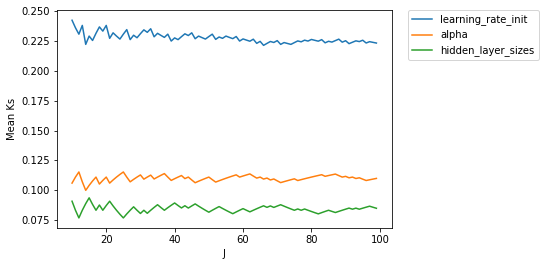

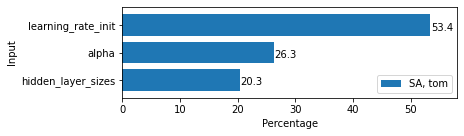

In [ ]:
sa.TOM(cvres_df.drop('RMSE', axis=1), cvres_df.RMSE, J=100, dummy=False)

See hyperparameter distributions leading to 20% best RMSE.

,RMSE,hidden_layer_sizes,alpha,learning_rate_init
3,4.045421,0.0,0.001,0.001
6,3.837222,1.0,0.010,0.001
9,3.908810,0.0,0.010,0.001


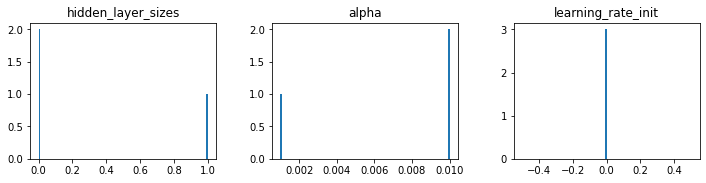

In [ ]:
cvres_df.loc[cvres_df.RMSE > cvres_df.RMSE.quantile(0.8)].drop('RMSE', axis=1).hist(
    bins=100, figsize=(cvres_df.shape[1]*3,2.5), layout=(1, cvres_df.shape[1]-1), grid=False);
cvres_df.loc[cvres_df.RMSE > cvres_df.RMSE.quantile(0.8)]

### Plot y-y scatter

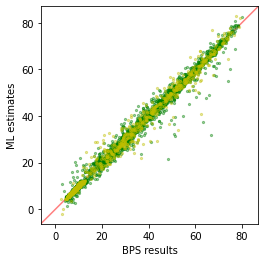

In [ ]:
fig, ax = plt.subplots()
# plt.scatter(y_train_pred, y_train, alpha=0.5, s=1, c='g')
# plt.scatter(y_train_pred, y_train, alpha=0.3, s=1)
plt.scatter(y_train_full, y_train_full_pred, alpha=0.4, s=5, c='g')
plt.scatter(y_test, y_test_pred, alpha=0.4, s=5, c='y')

plt.xlabel("BPS results")
plt.ylabel("ML estimates")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'r-', alpha=0.5, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')

## New samples

In [ ]:
X_pdfs = obtain_pdfs(X, verbose=True)
# X_pdfs

x0  Height            uniform    [5.15, 160.0]
x1  Window tilt       uniform    [1.01, 15.0]
x2  Sill height       uniform    [0.051, 0.799]
x3  Hzl glz percent   uniform    [0.6, 0.999]
x4  LT                discrete   [60 71 51]
x5  Blind pos         discrete   [0 1]


In [ ]:
N_new = 10000

# Sample N new samples
X_new = create_new_samples(X_pdfs, 100000)

# Transform machine learning model
x_new_prep = full_pipeline.transform(X_new)
# x_new_prep = X_new # For Random Forest with no transforms

# Make predictions
y_new = model.predict(x_new_prep)

# Combine input values and predicted output values
X_new = pd.DataFrame(X_new, columns=X.columns)
Y_new = pd.DataFrame(y_new, columns=y_labels)
XY_new = pd.concat([X_new, Y_new], axis=1)

XY_new

,Height,Window tilt,Sill height,Hzl glz percent,LT,Blind pos,min DA,Avg DA,Max solar gain,Cooling load,Heating load,Lighting
0,111.474721,14.947459,0.714496,0.636888,60.0,0.0,14.191742,46.334979,23.429175,5.447023,5.361795,10.453411
1,15.827236,14.746626,0.580016,0.803857,71.0,0.0,26.364032,53.901004,27.113038,6.257283,7.011620,11.610940
2,68.866803,13.797115,0.675082,0.696901,51.0,1.0,3.414286,37.734404,18.991182,5.212876,6.572548,10.940398
3,56.252286,8.597376,0.087383,0.740817,51.0,0.0,11.871623,45.114903,27.714850,5.692381,8.650811,11.293958
4,106.128779,11.787360,0.243805,0.978275,60.0,0.0,46.484093,66.955439,45.631997,6.200560,9.889187,8.802959
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,154.581854,9.904874,0.073421,0.856125,60.0,0.0,56.459825,70.509156,43.138348,5.918335,8.385399,7.970823
99996,67.182079,13.600551,0.121346,0.918548,71.0,1.0,35.532826,61.672519,50.575927,6.967078,10.467839,9.952610
99997,7.582667,4.036689,0.202080,0.906818,71.0,1.0,49.761778,71.053240,43.484449,7.453527,9.456574,10.359289
99998,70.551252,14.961541,0.798319,0.678418,60.0,0.0,2.831516,39.273586,21.029325,5.570830,5.604468,11.566525


See distributions of original and predicted outputs.

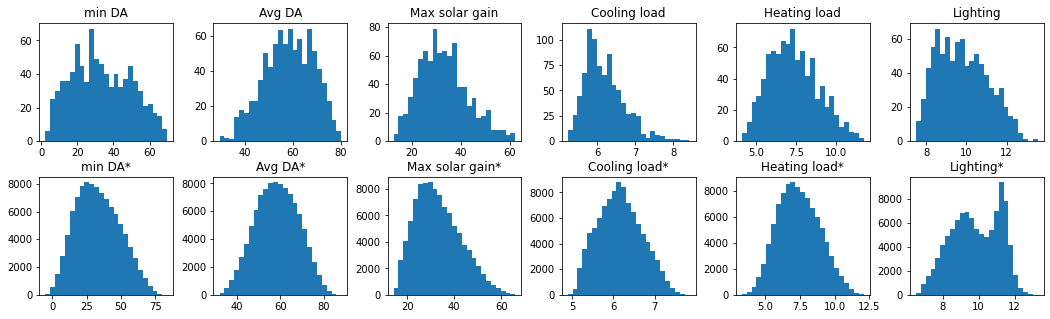

In [ ]:
Y_new_ = Y_new.copy()
Y_new_.columns = [s + '*' for s in Y_new.columns.to_list()]

YY_ = pd.concat([Y, Y_new_], axis=1)
YY_.hist(figsize=(Y.shape[1]*3, 5), bins=25, layout=(2, Y.shape[1]), grid=False);

Export predicted dataset to txt-file.

In [ ]:
SAVE_NEW_SAMPLES = True
if SAVE_NEW_SAMPLES:
  XY_new.to_csv(my_path + file_name_only + '_' + str(N_new) + '.csv', sep='\t', index=False)

# Dev

## Links

- [Allow figures to be returned from functions](https://stackoverflow.com/questions/17549713/how-to-have-a-function-return-a-figure-in-python-using-matplotlib
)
- [Number of figures](https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python)
- [Nested dicts](https://www.learnbyexample.org/python-nested-dictionary/)
- [Merge dictionaries](https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-taking-union-of-dictiona)
- Max letters in list of strings: `max(a_list, key=len)`
- [Clear output using code](https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code)


## Code snippets

In [ ]:
# forest = RandomForestRegressor(n_estimators=100, max_features=2, max_depth=3, bootstrap=True, n_jobs=-1, verbose=0, criterion='mse') #max_leaf_nodes=200, 
# forest.fit(cvres_df.drop('RMSE', axis=1).values, cvres_df.RMSE.values)
# forest.feature_importances_

In [ ]:
# import plotly.express as px
# px.parallel_coordinates(cvres_df, color="RMSE", height=300, width=500,
#                         color_continuous_scale=px.colors.diverging.Tealrose)

In [ ]:
cvres_df.loc[cvres_df['hidden_layer_sizes'] == (20,20), 'hidden_layer_sizes'] = 220
cvres_df.loc[cvres_df['hidden_layer_sizes'] == (50,50), 'hidden_layer_sizes'] = 250
cvres_df.loc[cvres_df['hidden_layer_sizes'] == (20,20,20), 'hidden_layer_sizes'] = 320
cvres_df['hidden_layer_sizes'] = cvres_df['hidden_layer_sizes'].astype('float64')
cvres_df

(Vincent dataset) Split SHGC and LT and keep only one input with numeric values

In [ ]:
# X[['SF','LT']] = X['in:SF LT'].str.split('/',expand=True)
# X.drop(columns=['in:SF LT', 'LT'], inplace=True)
# X.SF = X.SF.astype('float64')
# XY = pd.merge(X, Y, left_index=True, right_index=True, how='outer')

In [ ]:
x = XY[['insulation_type', 'blind_position', 'light_control', 'hx_system']].copy()
x1 = XY['insulation_type'].copy()
# x['blind_position'].value_counts()
x1.value_counts()
enc = OrdinalEncoder()
enc.fit_transform(x)

array([[1., 0., 0., 2.],
       [0., 2., 0., 0.],
       [2., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.]])

In [ ]:
forest = RandomForestRegressor(n_estimators=10, max_features=5, max_depth=5, bootstrap=True, n_jobs=-1, verbose=0, criterion='mse') #max_leaf_nodes=200, 
forest.fit(x_train_prepared, y_train)



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
forest.feature_importances_.shape

(24,)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def sa_multiple(X, Y, J=50, plot=True, verbose=True):
  """Perform sensitivity analysis for each output in matrix using SAtom

  Parameters:
  X (pandas.DataFrame): DataFrame with numeric input values
  Y (pandas.DataFrame): DataFrame with numeric output values

  Returns:
  pandas.DataFrame indexed with input names and columns with SA metrics for each output

  """
  # Loop and perform SA for each output
  Y_SA = np.zeros([X.shape[1], Y.shape[1]])
  for i, col in enumerate(Y.columns):
    print(f'({i+1}/{Y.shape[1]}) {"Performs TOM SA for:" :>20}  {col}')
    tom = sa.TOM(X, Y[col], J=J, verbose=False, dummy=False)
    KS_means = np.reshape(np.transpose(tom.KS_df.tail(1).values),-1)
    KS_means = KS_means / sum(KS_means) * 100 # Convert to percentages
    Y_SA[:, i] = KS_means
    
  # Convert SA 
  Y_SA = pd.DataFrame(data=Y_SA, index=list(X.columns.values), columns=Y.columns)

  # Plot distributions and horisontal barplots with SA results
  if plot:
    n_outputs = Y_SA.shape[1]
    n_inputs = Y_SA.shape[0]
    fig, axes = plt.subplots(2, n_outputs, figsize=(2+n_outputs*1.7, 1+n_inputs*0.3), constrained_layout=True, gridspec_kw={'height_ratios': [1, 3]}) #  sharey='row',
    # fig.suptitle('Følsomhedsanalyse');
    for i_plot in range(n_outputs):
      sns.histplot(ax=axes[0, i_plot], data=Y, x=Y.columns[i_plot], stat="probability", element="step", fill=True, bins=25)
      sns.barplot(ax=axes[1, i_plot], y=Y_SA.index, x=Y_SA.iloc[:,i_plot])

      # Add labels
      axes[1, i_plot].spines['top'].set_visible(False)  
      axes[1, i_plot].spines['right'].set_visible(False)  
      for i, val in enumerate(Y_SA.iloc[:,i_plot].values):
          axes[1, i_plot].text(val+0.1, i+0.2, str(round(val,1)), size=8)

      axes[0, i_plot].set_title(Y_SA.columns[i_plot], fontsize=10)
      axes[0, i_plot].xaxis.label.set_visible(False)
      if i_plot >= 1:
        axes[0, i_plot].get_yaxis().set_visible(False)
        axes[1, i_plot].get_yaxis().set_visible(False)
      else:
        axes[0, i_plot].yaxis.set_ticks([])

  return Y_SA, fig  

In [ ]:
for id, info in res.items():
    print("\nVar:", id)
    for key in info:
        print(key + ':', info[key])


Var: x0
idx: 0
param: Height
pdf: uniform
args: [0, 1]

Var: x1
idx: 1
param: Window tilt
pdf: uniform
args: [0, 1]

Var: x2
idx: 2
param: Sill height
pdf: uniform
args: [0, 1]

Var: x3
idx: 3
param: Hzl glz percent
pdf: uniform
args: [0, 1]

Var: x4
idx: 4
param: LT
pdf: discrete
args: [60 71 51]

Var: x5
idx: 5
param: Blind pos
pdf: discrete
args: [0 1]
